In [33]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [111]:
from pathlib import Path
import numpy as np
import pandas as pd
import time
import pdb
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from collections import defaultdict, Counter

In [94]:
DATA = Path('../Data')

plt.rcParams.update({'font.size': 16})

# Load Data

In [4]:
%time df = pd.read_csv(DATA/'train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})
df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'ttf'}, inplace=True)

Wall time: 2min 15s


In [23]:
trans = np.where( df.ttf.values[1:] - df.ttf.values[:-1] > 0 )[0]

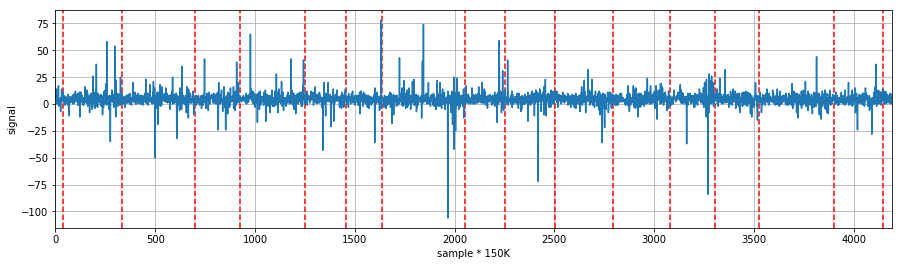

In [39]:
plt.figure(figsize=(15,4))
for t in trans:
    plt.axvline(t/150e3, linestyle='--', color='red')
plt.plot(df.signal[slice(0,len(df),150000)].values)
plt.xlim((0,len(df)/150e3))
plt.xlabel('sample * 150K')
plt.ylabel('signal')
plt.grid()

In [52]:
meta = pd.read_pickle('train.meta.covs.pickle')
n_segs = meta.shape[0]
meta.shape

(21988, 7)

Text(0,0.5,'TTF')

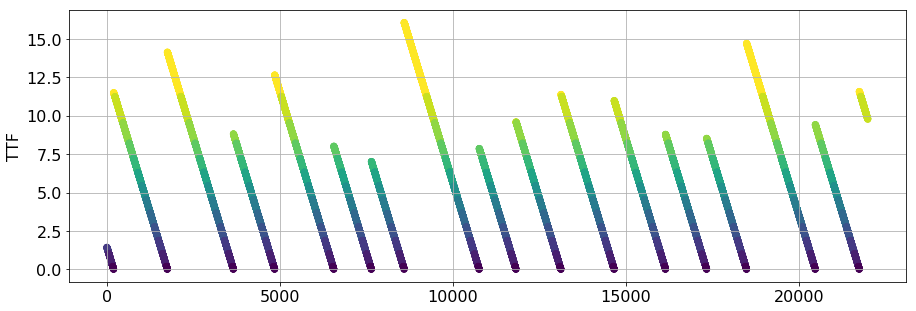

In [213]:
plt.figure(figsize=(15,5))
plt.scatter(x=np.arange(len(meta)), y=meta.qt, c=meta.qt_class)
plt.grid()
plt.ylabel('TTF')

# Predictions

Contents:
- Predictions vs. time
- Relations between models
- Models errors
- Predictions per bucket

In [65]:
preds = pd.read_pickle('data2.covs.pickle')
n_models = preds.shape[1]
models = preds.columns
preds.shape

(21988, 14)

In [91]:
stds = ['std' in m for m in models]
estimates = [m for m,s in zip(models,stds) if not s]
stds = [m for m,s in zip(models,stds) if s]
n_est = len(estimates)
n_std = len(stds)
(n_est, n_std)

(11, 3)

In [116]:
errs = preds[estimates].copy()
for m in errs.columns:
    errs[m] = preds[m] - meta.qt

### Predictions vs. Time

In [128]:
quake_starts = np.where(np.diff(meta.qt)>0)[0] + 1
def plot_quakes(ax, full=False):
    for qs in quake_starts:
        ax.axvline(qs, linestyle='--', color='red')
    if full:
        ax.plot(meta.qt, 'r-', linewidth=1, label='True TTF')
    ax.set_xlim((0,len(meta)))
    ax.set_xlabel('segment')
    ax.grid()

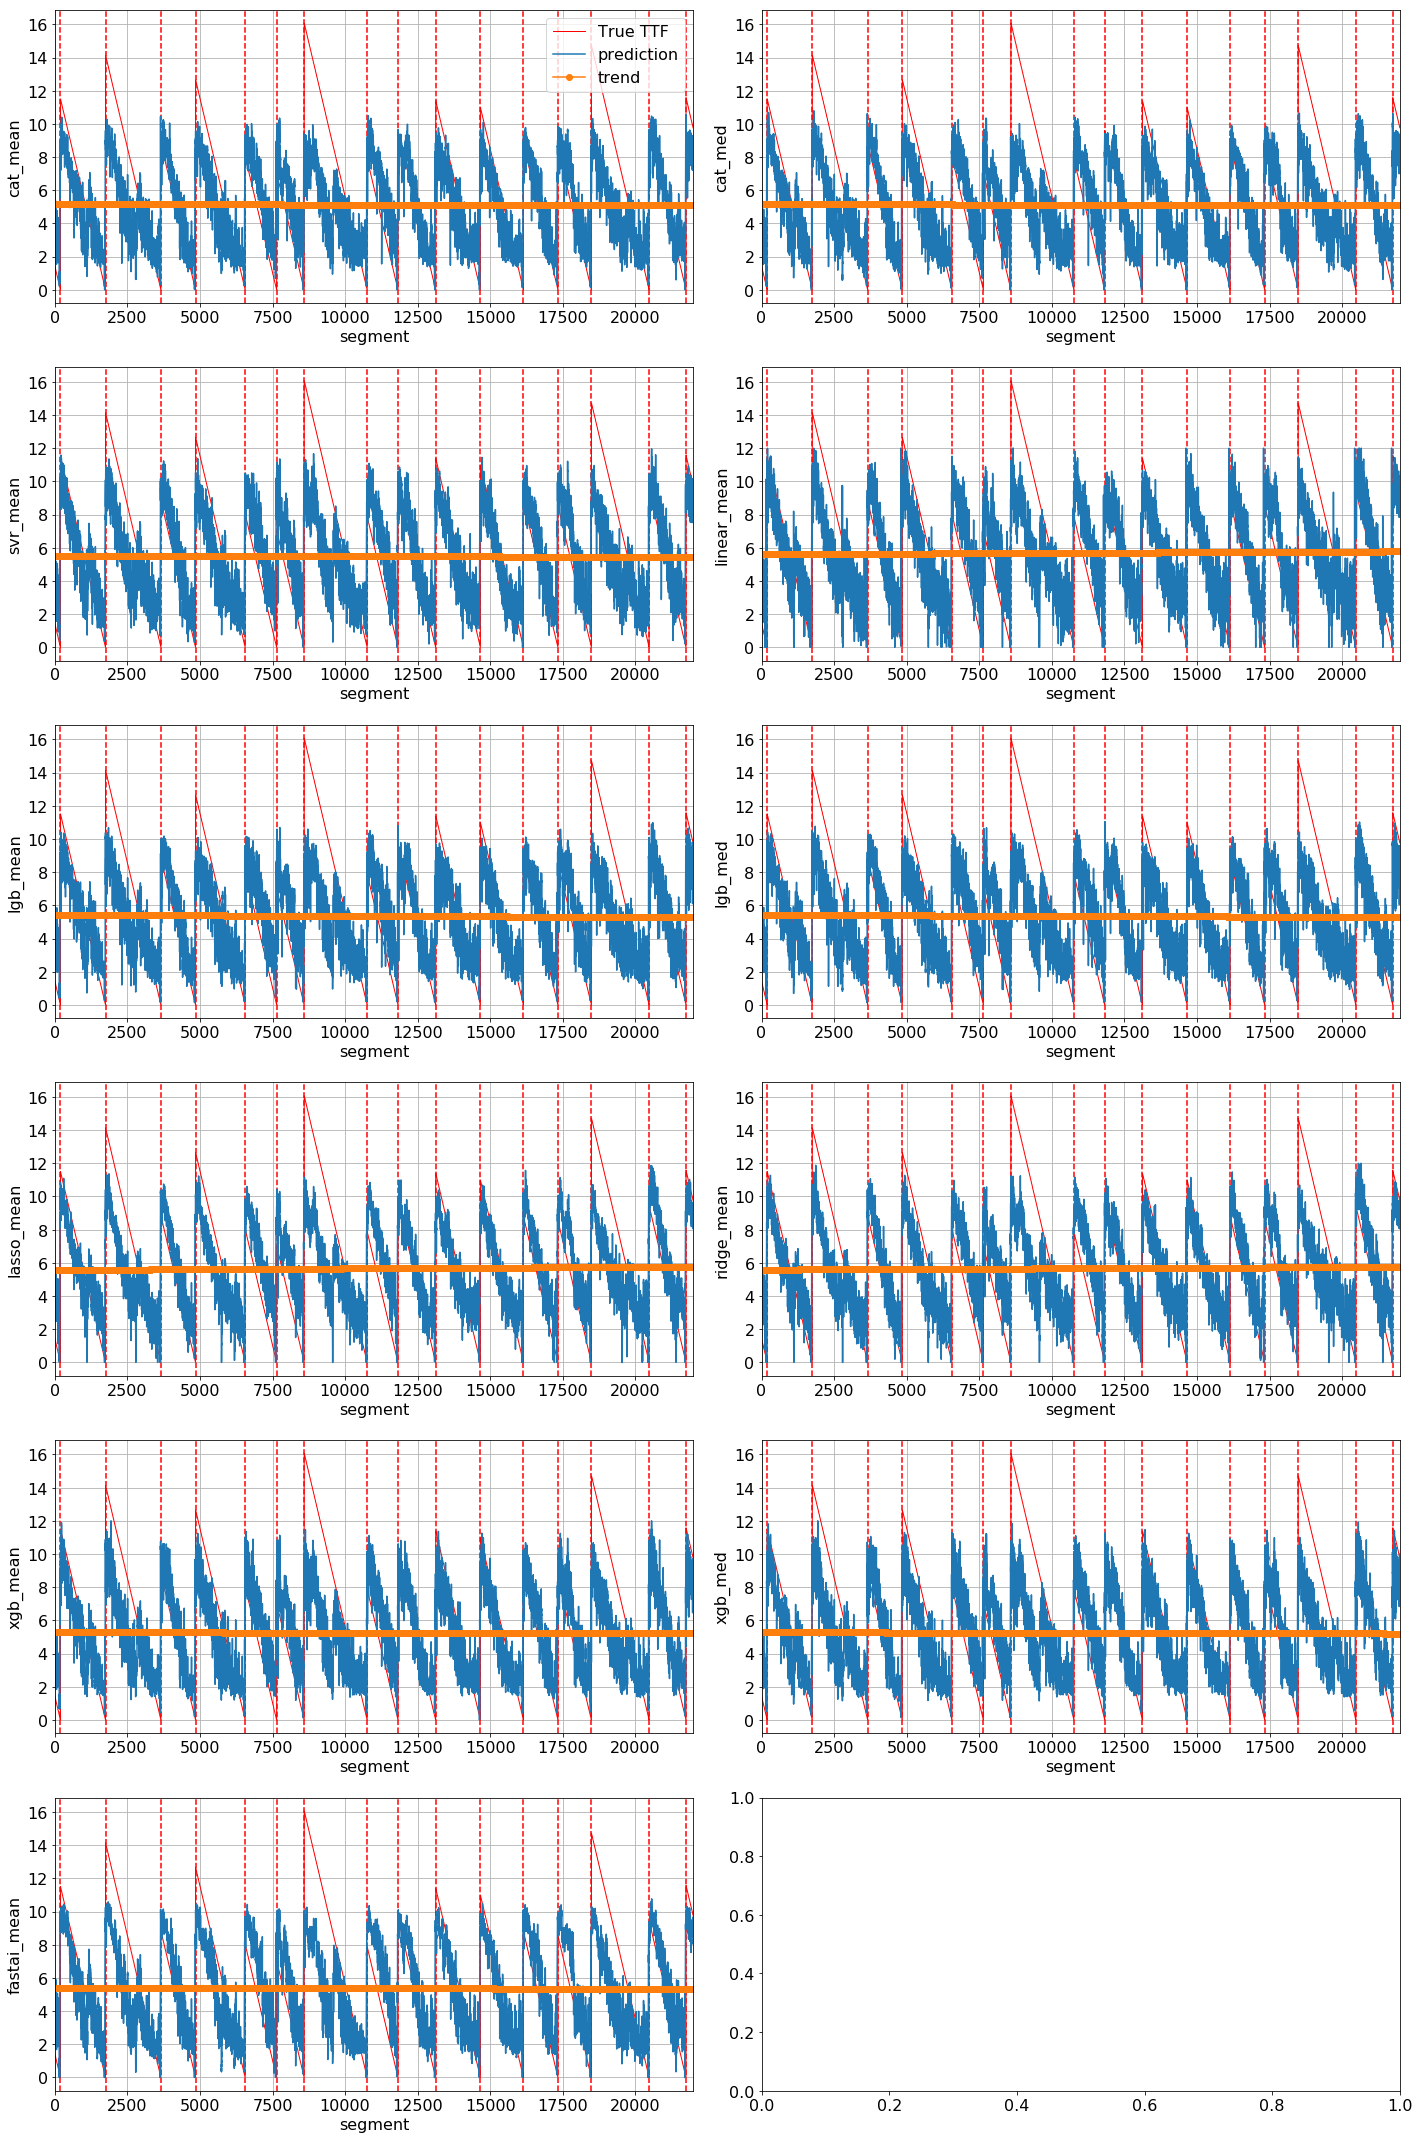

In [129]:
# predictions over time
fig, axs = plt.subplots(6,2, figsize=(20,30))
segs = list(range(n_segs))
for i,m in enumerate(estimates):
    ax = axs[i//2, i%2]
    plot_quakes(ax, True)
    ax.plot(preds[m], label='prediction')
    z = np.polyfit(segs, preds[m], 1)
    p = np.poly1d(z)
    ax.plot(segs,p(segs),"o-", label='trend')
    ax.set_ylabel(m)
    if i==0:
        ax.legend()
plt.tight_layout()

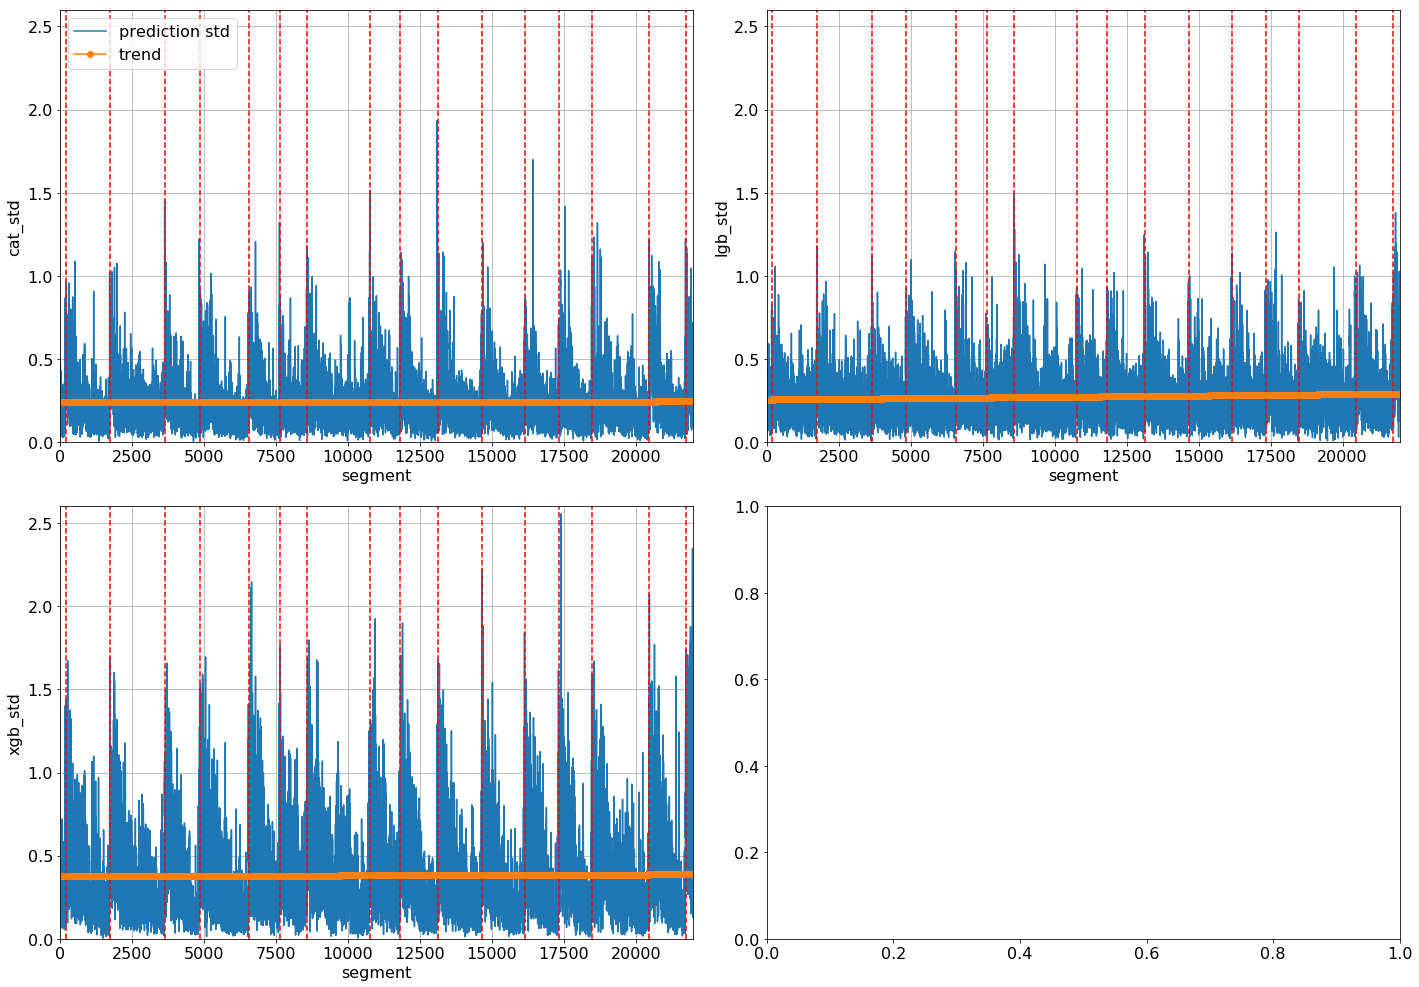

In [131]:
fig, axs = plt.subplots(2,2, figsize=(20,14))
for i,m in enumerate(stds):
    ax = axs[i//2, i%2]
    ax.plot(preds[m], label='prediction std')
    plot_quakes(ax)#, True)
    z = np.polyfit(segs, preds[m], 1)
    p = np.poly1d(z)
    ax.plot(segs,p(segs),"o-", label='trend')
    ax.set_ylabel(m)
    if i==0:
        ax.legend()
    ax.set_ylim((0,2.6))
plt.tight_layout()

### Relations between Models

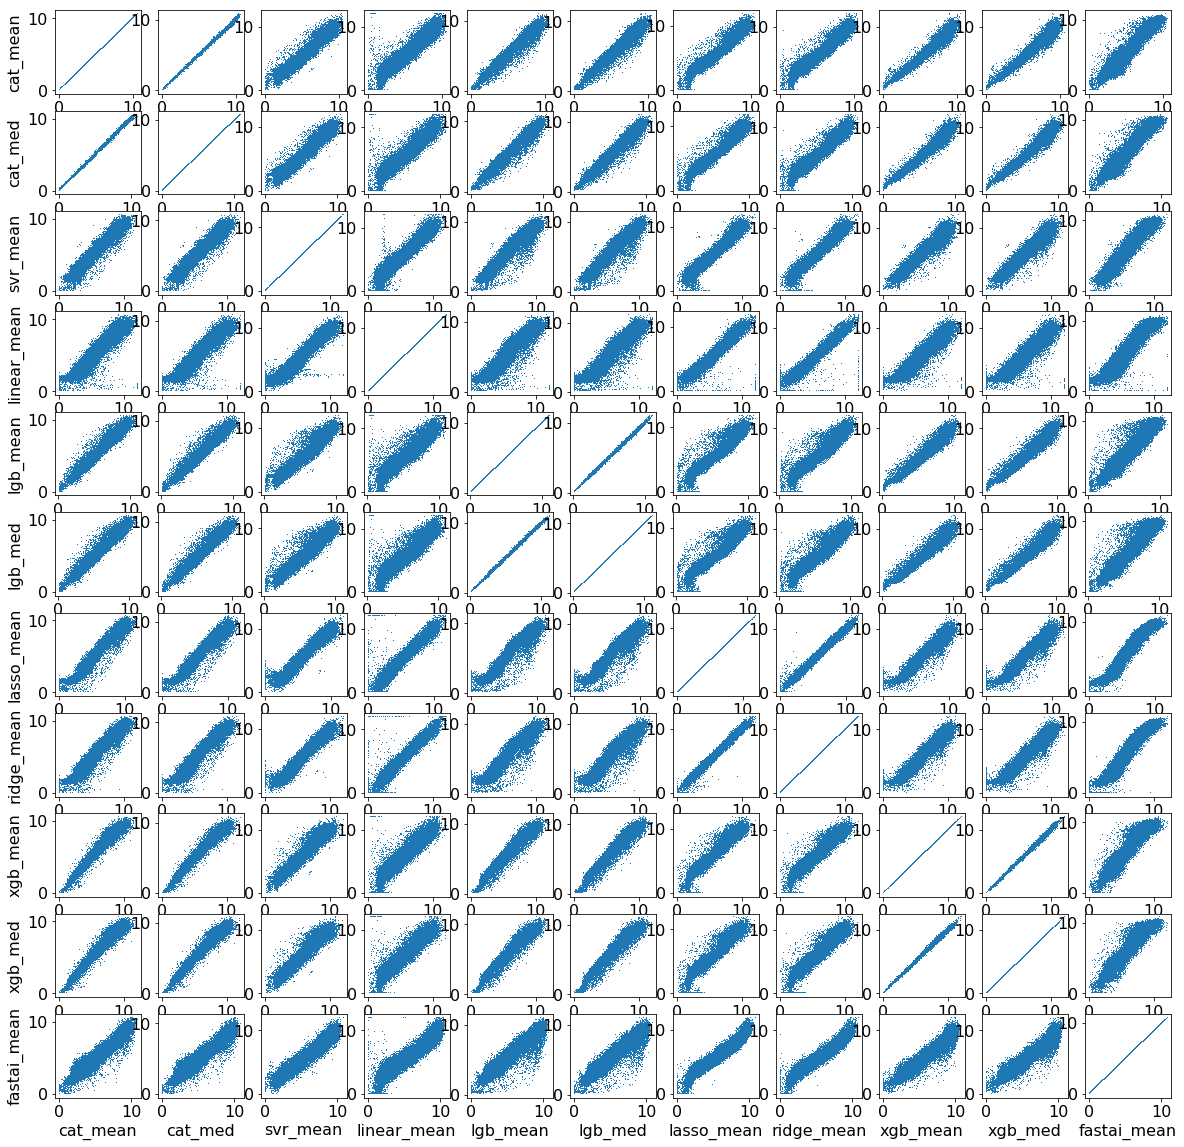

In [103]:
# relations between predictions
fig, axs = plt.subplots(n_est,n_est, figsize=(20,20))
for i,m1 in enumerate(estimates):
    for j,m2 in enumerate(estimates):
        ax = axs[i,j]
        ax.plot(preds[m1],preds[m2],',')
        if i == n_est-1:
            ax.set_xlabel(m2)
        if j == 0:
            ax.set_ylabel(m1)
#plt.tight_layout()

Text(0.5,1,'Correlation Map')

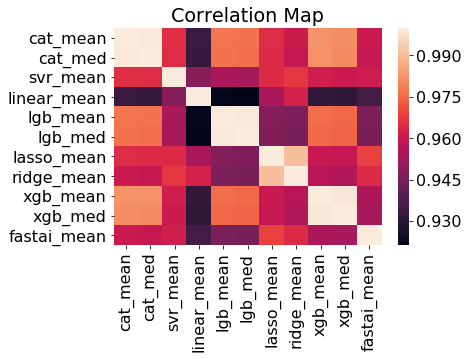

In [224]:
sns.heatmap(
    pd.DataFrame(np.array([[np.corrcoef(preds[m1],preds[m2])[0,1] for m2 in estimates] for m1 in estimates]),
                 columns=estimates, index=estimates)
)
plt.title('Correlation Map')

Text(0.5,1,'L1-distance Map')

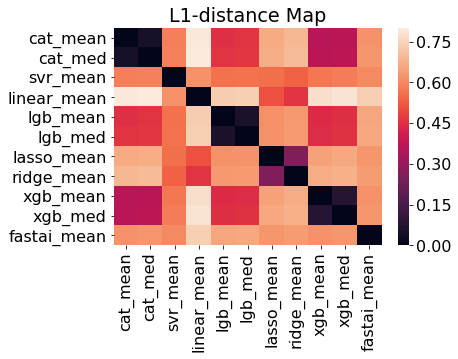

In [225]:
sns.heatmap(
    pd.DataFrame(np.array([[(preds[m1]-preds[m2]).abs().mean() for m2 in estimates] for m1 in estimates]),
                 columns=estimates, index=estimates)
)
plt.title('L1-distance Map')

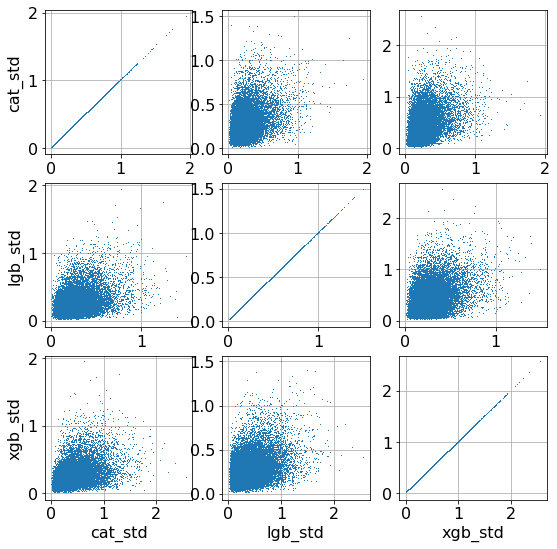

In [133]:
fig, axs = plt.subplots(n_std,n_std, figsize=(9,9))
for i,m1 in enumerate(stds):
    for j,m2 in enumerate(stds):
        ax = axs[i,j]
        ax.plot(preds[m1],preds[m2],',')
        ax.grid()
        if i == n_std-1:
            ax.set_xlabel(m2)
        if j == 0:
            ax.set_ylabel(m1)

### Models Errors

{'cat_mean': 2.03,
 'cat_med': 2.031,
 'fastai_mean': 2.057,
 'lasso_mean': 2.091,
 'lgb_mean': 2.027,
 'lgb_med': 2.029,
 'linear_mean': 2.106,
 'ridge_mean': 2.103,
 'svr_mean': 2.057,
 'xgb_mean': 2.014,
 'xgb_med': 2.014}

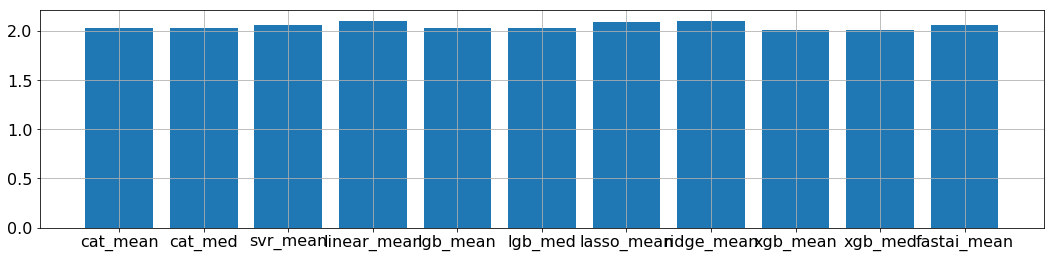

In [210]:
plt.figure(figsize=(18,4))
plt.bar(x = estimates, height = [(preds[m]-meta.qt).abs().mean() for m in estimates])
plt.grid()
{m: round((preds[m]-meta.qt).abs().mean(),3) for m in estimates}

Text(0,0.5,'Error')

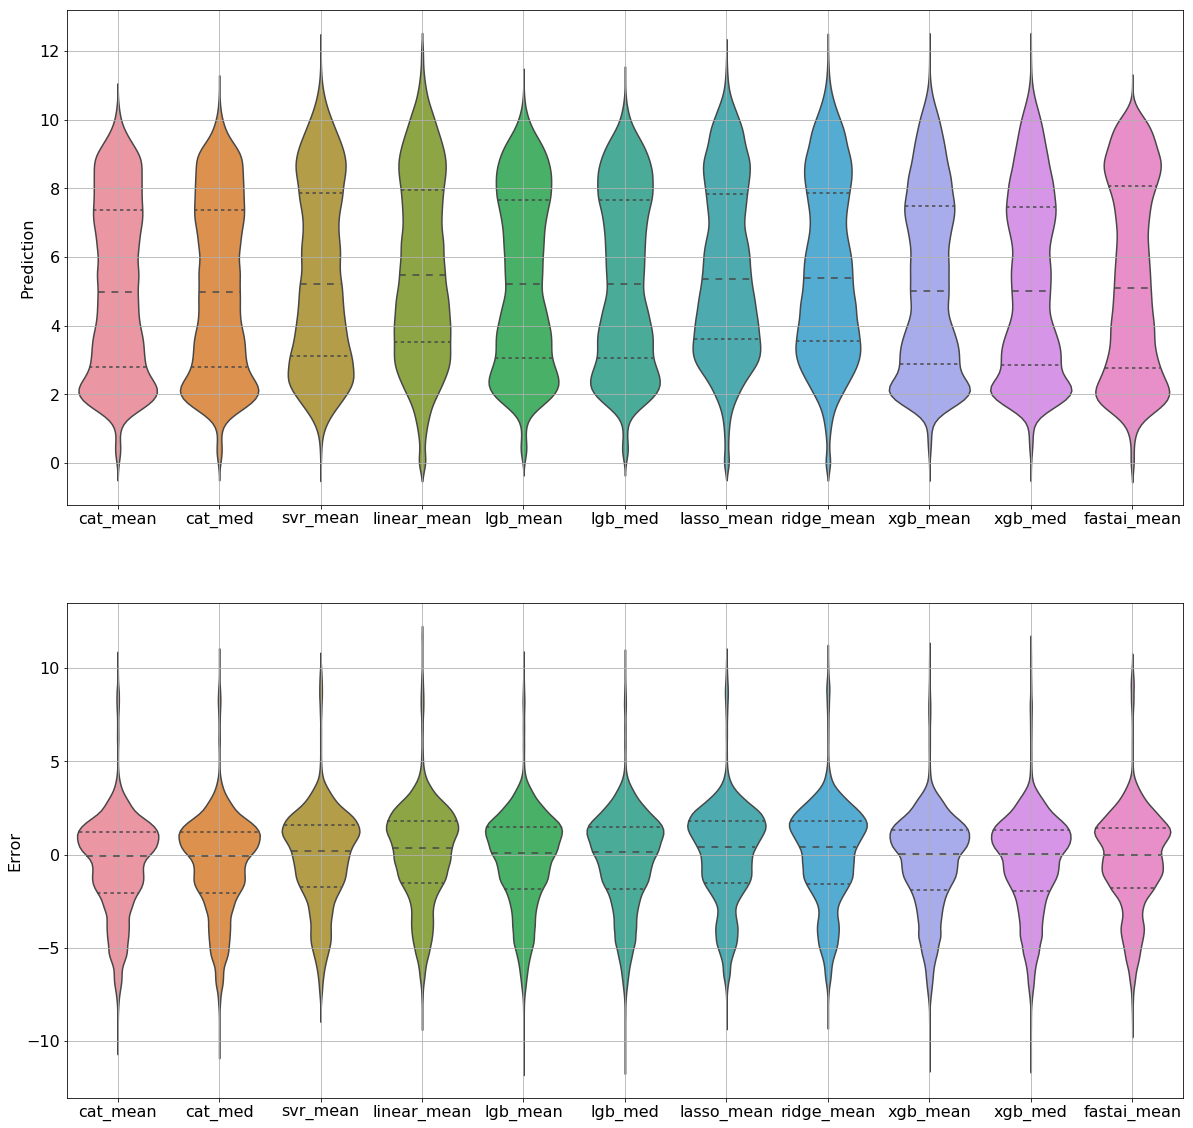

In [197]:
fig, axs = plt.subplots(2,1, figsize=(20,20))

ax = axs[0]
sns.violinplot(data=preds[estimates], inner='quart', ax=ax, bw=0.1)
ax.grid()
ax.set_ylabel('Prediction')

ax = axs[1]
sns.violinplot(data=errs[estimates], inner='quart', ax=ax, bw=0.1)
ax.grid()
ax.set_ylabel('Error')

### Predictions per Bucket

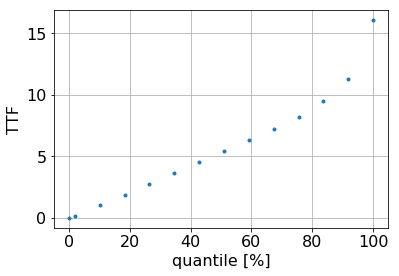

In [149]:
thres1 = 0.1917
q1 = np.mean(meta.qt<thres1)
thresholds = np.concatenate(((0, thres1), np.quantile(meta.qt[meta.qt>thres1], np.arange(0,1.01,1/12))[1:]))
plt.plot(np.concatenate(((0,), 100*(q1+(1-q1)*np.arange(0,1.01,1/12)))), thresholds, '.')
plt.xlabel('quantile [%]')
plt.ylabel('TTF')
plt.grid()

In [171]:
meta['qt_class'] = [np.sum(t>thresholds) for t in meta.qt]
meta['qt_class_cent'] = list(map(lambda i: (thresholds[i-1]+thresholds[i])/2, meta['qt_class']))
Counter(meta.qt_class_cent)

Counter({0.09585: 436,
         0.6111491184708333: 1796,
         1.4593893822125: 1796,
         2.331751463091667: 1796,
         3.2227104645: 1796,
         4.1130983853375: 1796,
         5.0007234800875: 1796,
         5.890222970991667: 1796,
         6.782463788741666: 1796,
         7.7248766976875: 1796,
         8.8820683843375: 1796,
         10.403197066383331: 1796,
         13.665638803583331: 1796})

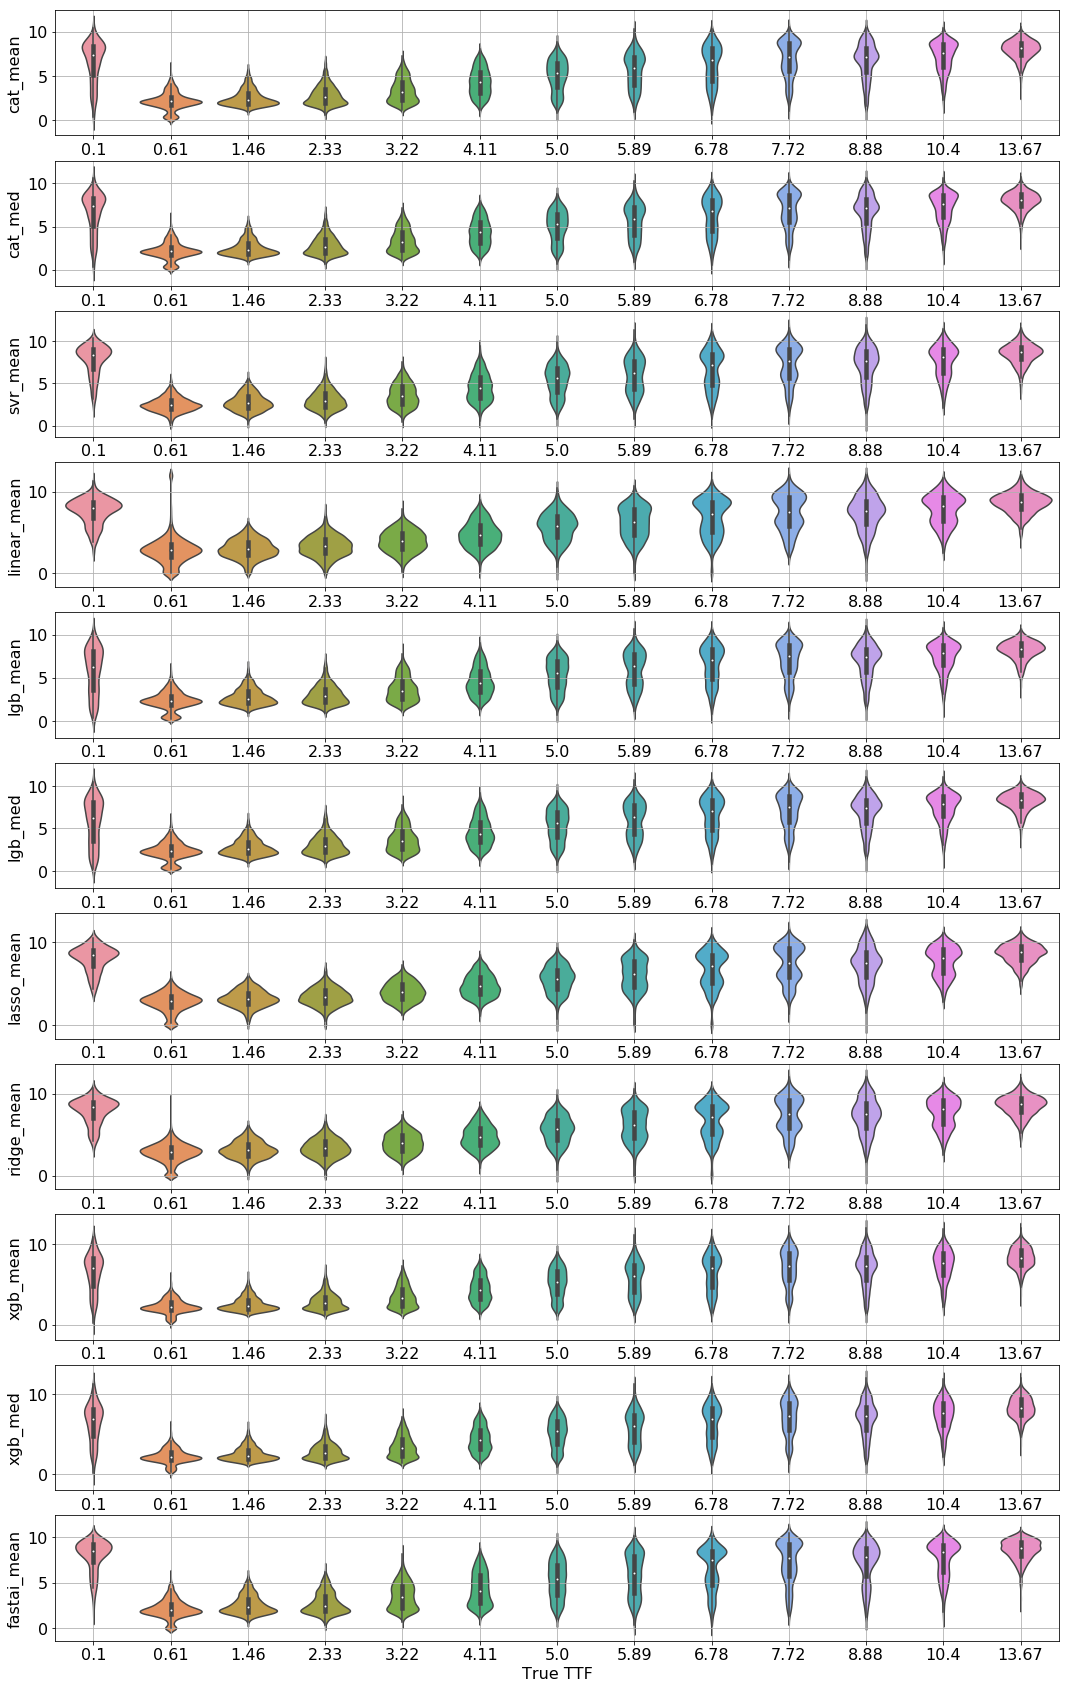

In [175]:
fig, axs = plt.subplots(n_est,1, figsize=(18,30))

for i,m in enumerate(estimates):
    ax = axs[i]
    sns.violinplot(data=pd.DataFrame({'True TTF':round(meta.qt_class_cent,2),m:preds[m]}), x='True TTF', y=m,
                   ax=ax, inner='quart')
    ax.grid()

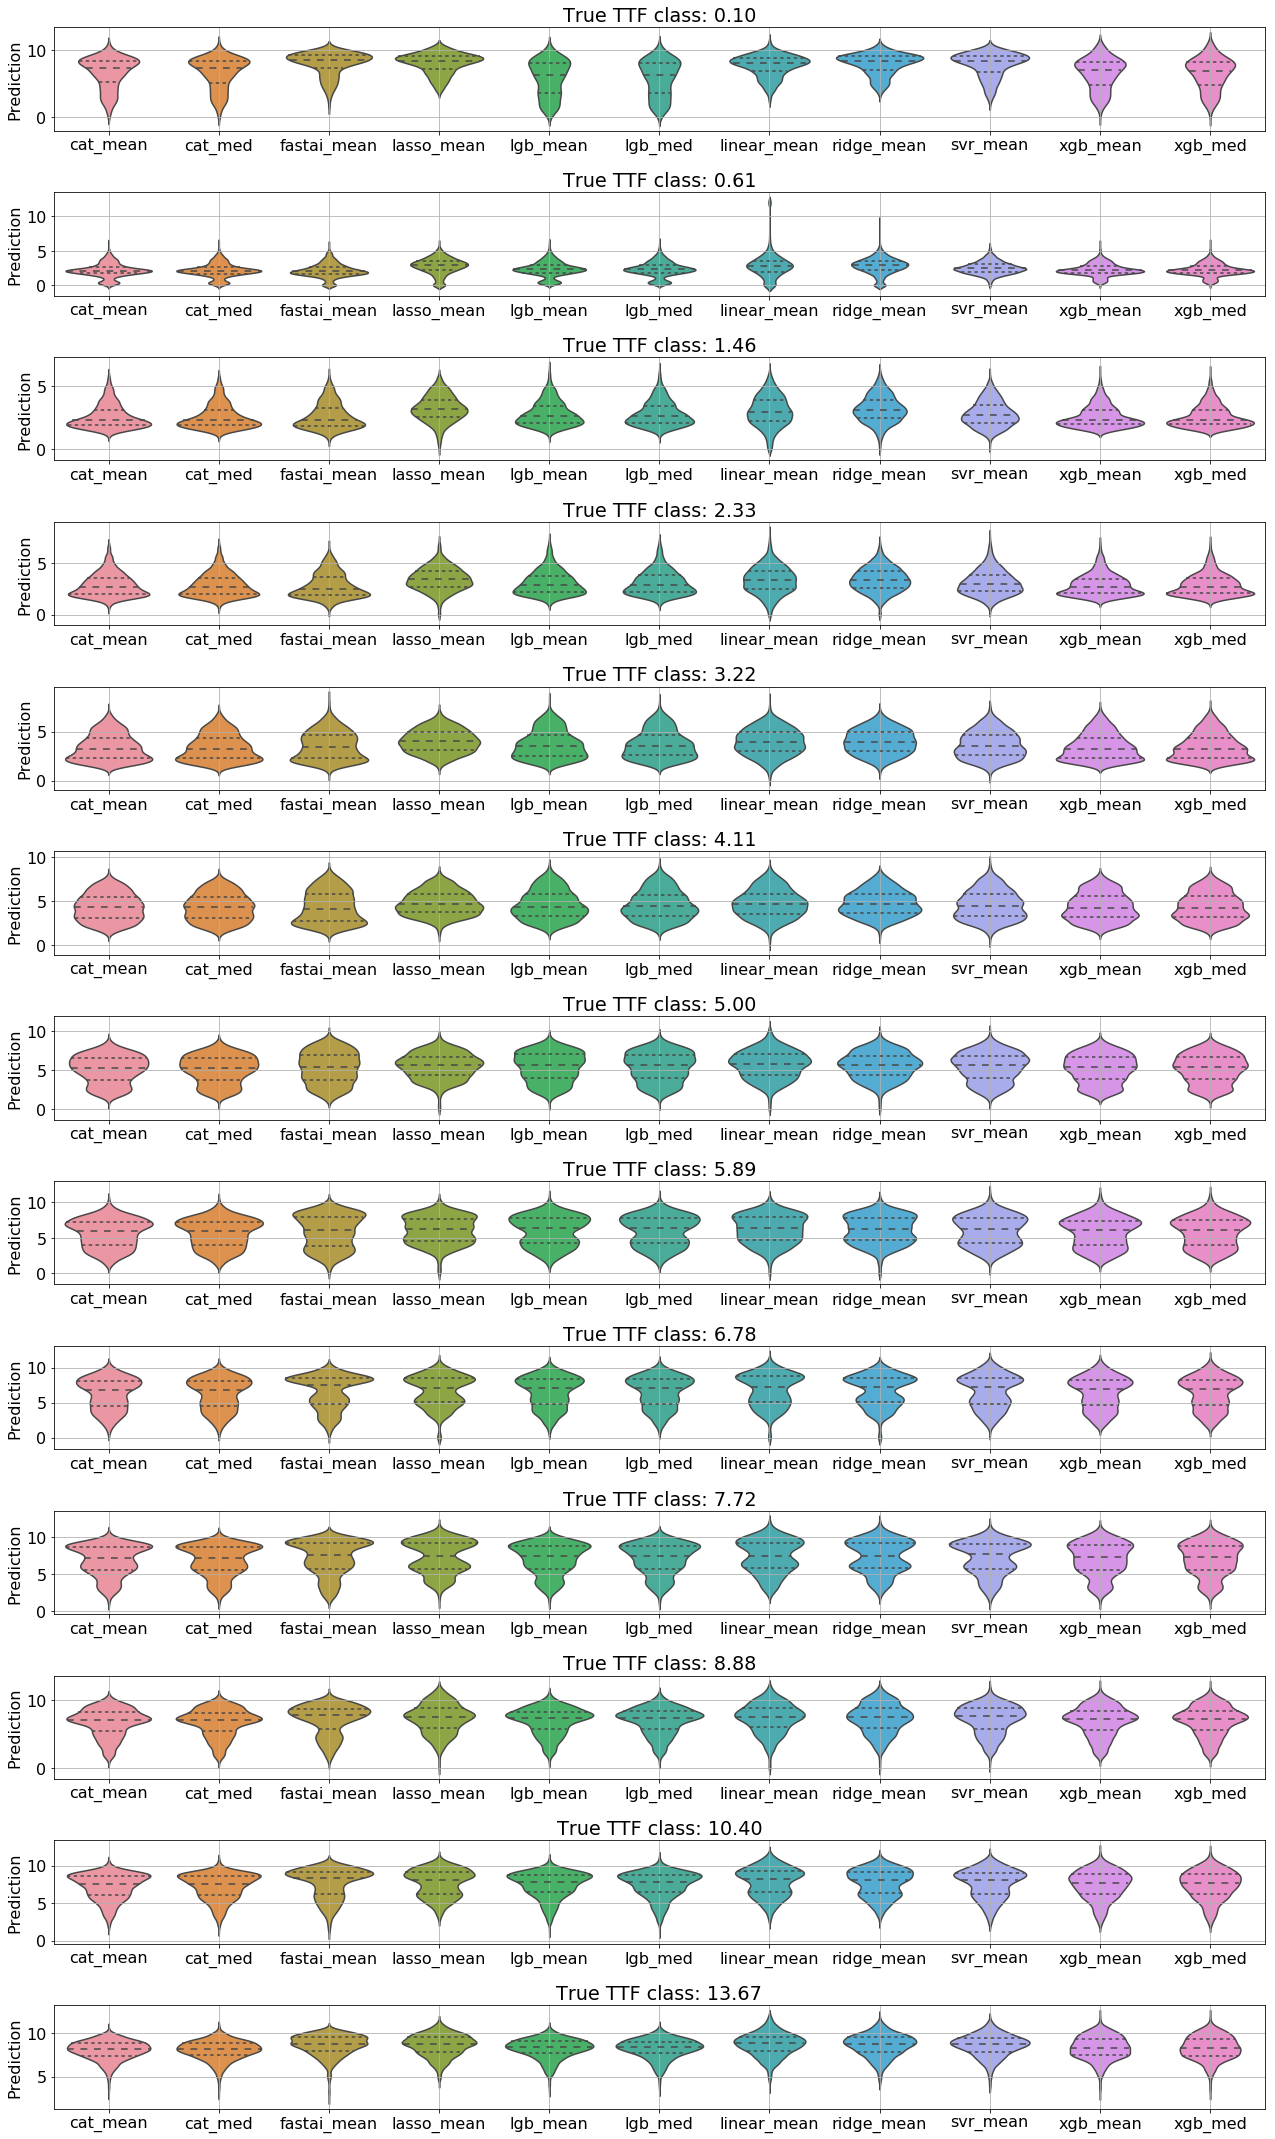

In [198]:
class_cents = np.unique(round(meta.qt_class_cent,2))
fig, axs = plt.subplots(len(class_cents),1, figsize=(18,30))

for i,c in enumerate(class_cents):
    ax = axs[i]
    sns.violinplot(data=pd.DataFrame({m: preds[m][round(meta.qt_class_cent,2)==c] for m in estimates}), ax=ax, inner='quart')
    ax.set_title(f'True TTF class: {c:.2f}')
    ax.set_ylabel('Prediction')
    ax.grid()
    
plt.tight_layout()

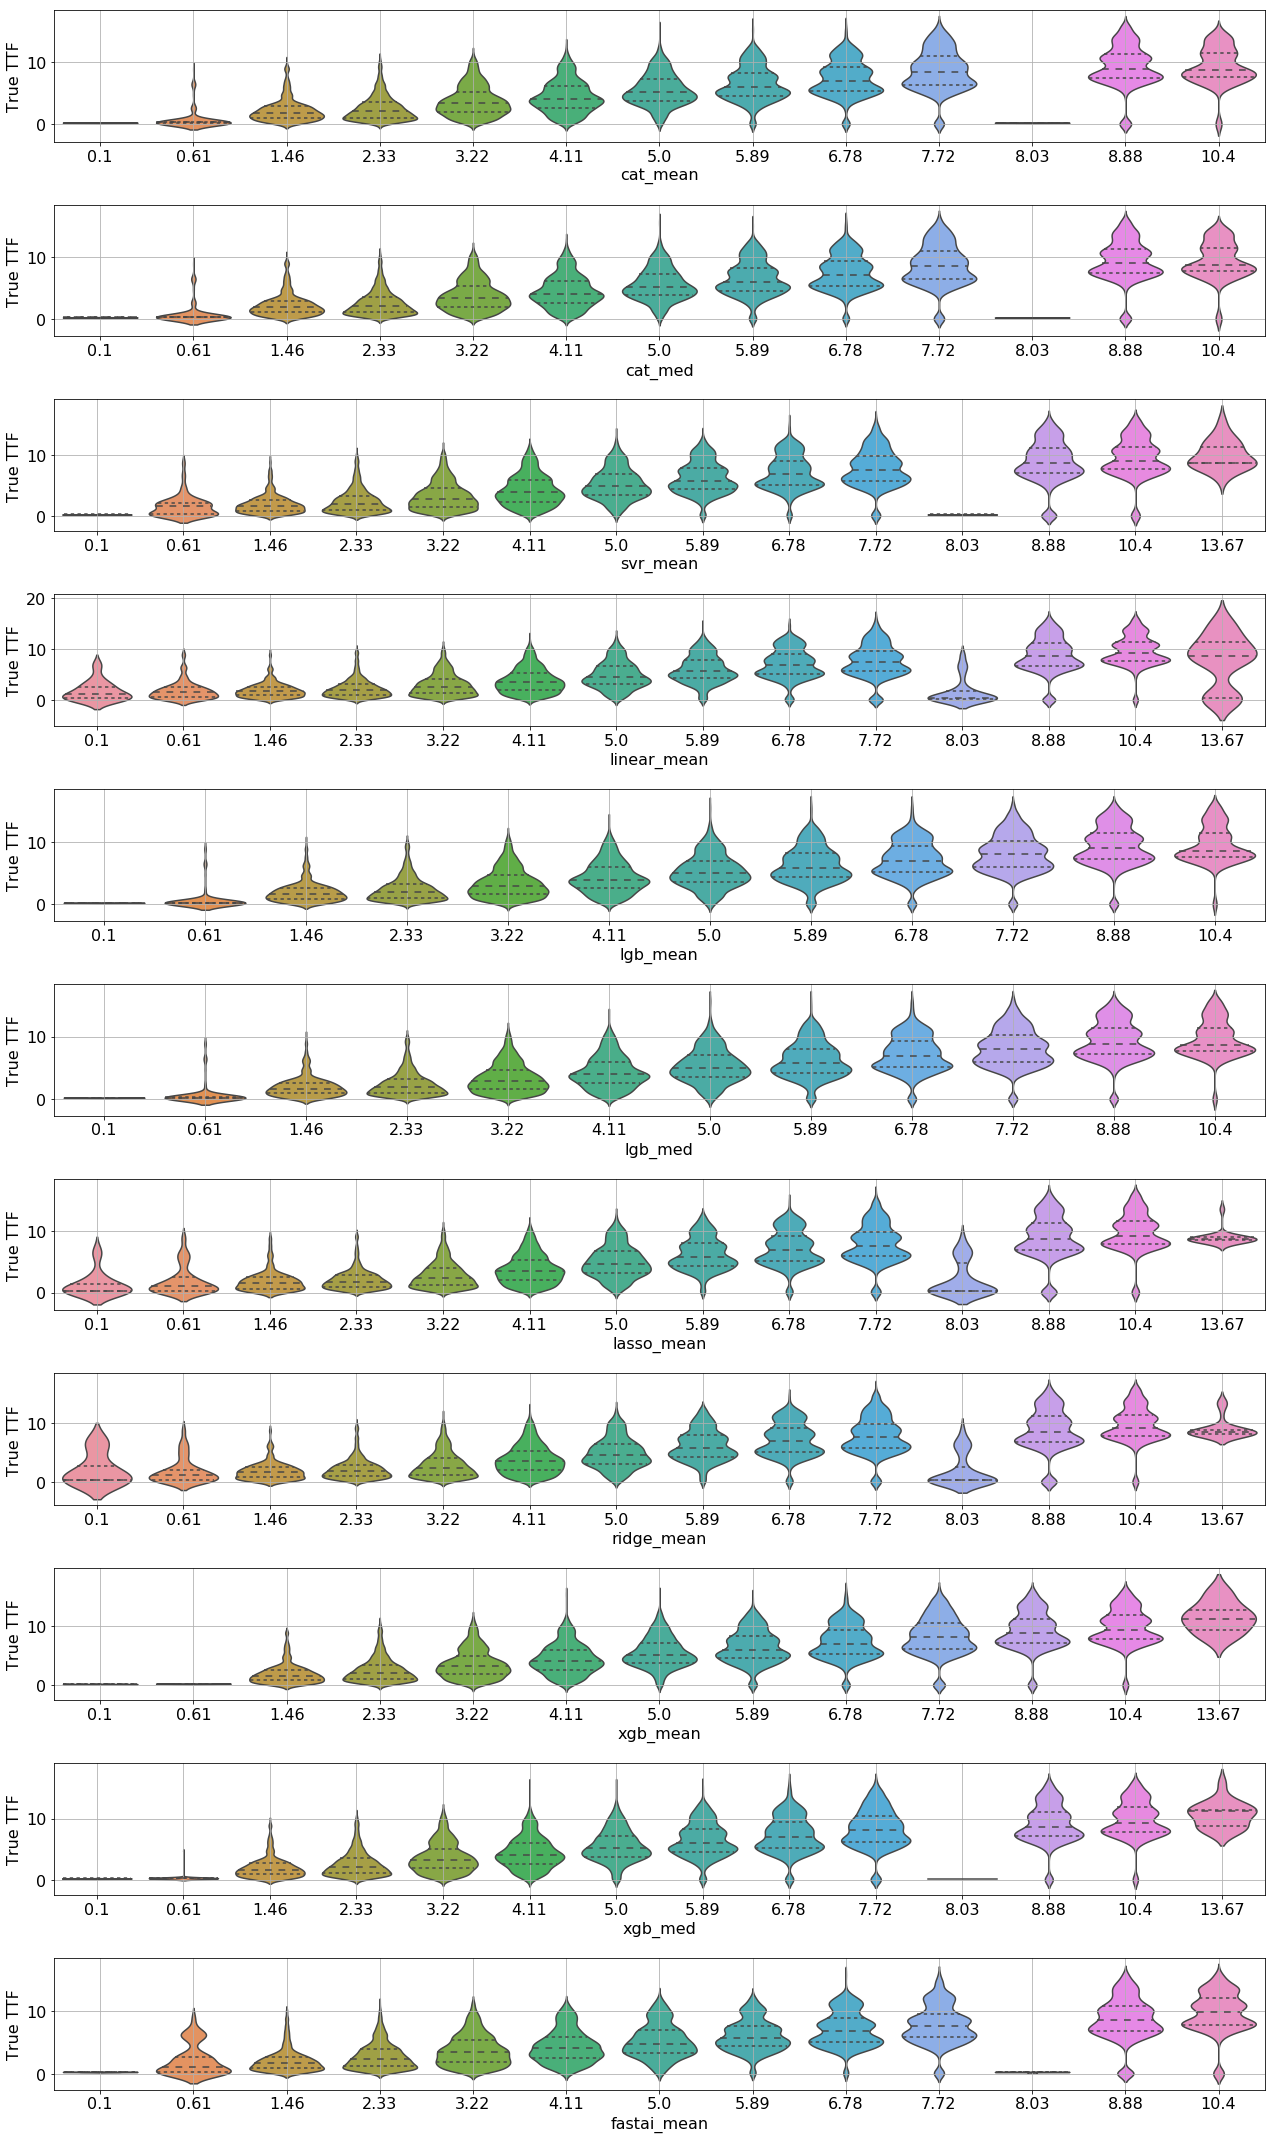

In [194]:
fig, axs = plt.subplots(n_est,1, figsize=(18,30))

for i,m in enumerate(estimates):
    ax = axs[i]
    pred_class = [np.sum(t>thresholds) for t in preds[m]]
    pred_class = np.array(list(map(lambda i: (thresholds[i-1]+thresholds[i])/2, pred_class)))
    sns.violinplot(data=pd.DataFrame({m:pred_class.round(2),'True TTF':meta.qt}), x=m, y='True TTF',
                   ax=ax, inner='quart', scale='width')
    ax.grid()
    
plt.tight_layout()